In [1]:
import os
import pandas as pd

from collections import Counter 
from wordcloud import WordCloud

from utils import preprocess

In [2]:
# read data
df = pd.read_json("../data/reviews_computers.json.gz", orient="records")
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df = df.sample(1000) # subset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 14739 to 65594
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   overall    1000 non-null   int64 
 1   vote       1000 non-null   int64 
 2   asin       1000 non-null   object
 3   text       1000 non-null   object
 4   summary    1000 non-null   object
 5   timestamp  1000 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 54.7+ KB


## Preprocessing

In [3]:
# apply preprocessing
df["preprocess"] = df["text"].apply(lambda x : preprocess(x))

/home/saiteki-kai/プロジェクト/進行中/data-analytics/venv/lib/python3.10/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [4]:
tokens = [word for doc in df["preprocess"] for sent in doc for word in sent]
c = Counter(tokens)

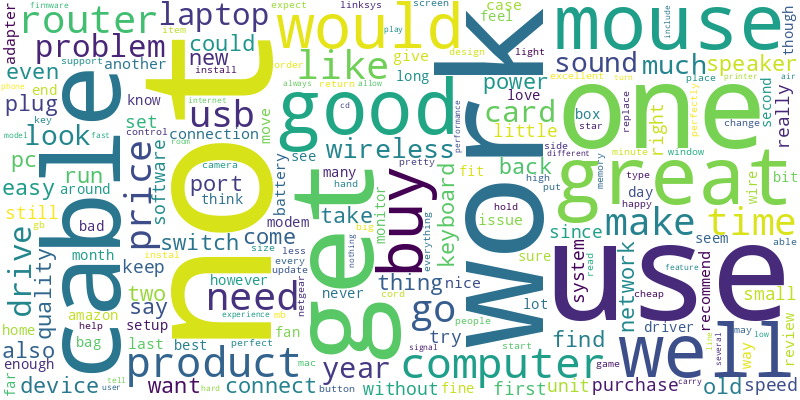

In [5]:
# generate the word cloud
w = WordCloud(width=800, height=400, background_color="white").fit_words(c)
w.to_image()

In [6]:
vocabulary = list(set(tokens))
print(len(vocabulary))

4977


## Generate data for ASUM

In [7]:
with open("../data/asum/WordList.txt", "w") as f:
  for word in vocabulary:
    f.write(f"{word}\n")

In [8]:
sentence_list = "../data/asum/BagOfSentences.txt"

if os.path.exists(sentence_list): 
  os.remove(sentence_list) 

with open(sentence_list, "a") as f:
  for doc in df["preprocess"]:
    f.write(f"{len(doc)}\n")
    for tokens in doc:
      indexes = " ".join([str(vocabulary.index(t)) for t in tokens])
      f.write(f"{indexes}\n")

In [ ]:
from utils import asum
asum("./data/asum/", "./output/", "0.1", "0.001/0.1/0", "1/1", "10")